**ЛР 5**  
**Вариант 20**

Часть 1

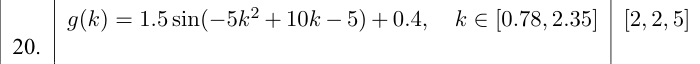

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import math
import numpy as np
import matplotlib.pyplot as plt
import time
import random

---

In [2]:
epochs = 1000
window = 10

seed = time.time()
random.seed()
torch.manual_seed(seed)

**Сеть Элмана**

In [3]:
class ElmanLayer(nn.Module):
  def __init__(self, in_features, out_features):
    super(ElmanLayer, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.w1 = torch.nn.Parameter(torch.randn(in_features, out_features))
    self.w2 = torch.nn.Parameter(torch.randn(out_features, out_features))
    self.b = torch.nn.Parameter(torch.randn(out_features))
    self.prev = torch.tensor(torch.zeros(in_features, out_features))

  def clear_memory(self):
    self.prev = torch.tensor(torch.zeros(self.in_features, self.out_features))

  def forward(self, input):
    d = torch.matmul(self.prev, self.w2)
    out = torch.matmul(input, self.w1)
    out = torch.add(out, d)
    out = torch.add(out, self.b)
    out = torch.tanh(out)
    self.prev = torch.tensor(out)
    return out

In [4]:
def make_signal(r1 = 2, r2 = 2, r3 = 5):
  k1, k2 = np.arange(0, 1, 0.01), np.arange(0.78, 2.35, 0.01)
  p1, p2 = np.sin(4 * np.pi * k1), (1.5 * np.sin(- 5 * k2 ** 2 + 10 * k2 - 5) + 0.4)
  t1, t2 = -1 * np.ones(len(p1)), np.ones(len(p2))

  assert len(k1) == len(p1) and len(k1) == len(t1)
  assert len(k2) == len(p2) and len(k2) == len(t2)

  signal = np.concatenate((np.tile(p1, r1), p2, np.tile(p1, r2), p2, np.tile(p1, r3), p2))
  labels = np.concatenate((np.tile(t1, r1), t2, np.tile(t1, r2), t2, np.tile(t1, r3), t2))

  return signal, labels

In [5]:
def get_train_data(signal, labels, window):
  signal_seq = [np.array(signal[i:i + window], dtype = np.float32) for i in range(0, len(signal) - window)]
  labels_seq = [np.array(labels[i:i + window], dtype = np.float32) for i in range(0, len(labels) - window)]

  output = [(x, y) for x, y in zip(signal_seq, labels_seq)]

  return output

---

In [6]:
elman = ElmanLayer(in_features=window, out_features=8)
linear = nn.Linear(in_features=8, out_features=window)
model = nn.Sequential(elman, linear)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [7]:
signal, labels = make_signal(r1 = 2, r2 = 2, r3 = 5)
train_dataset = get_train_data(signal, labels, window = window)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 1, shuffle = False)

model.train()
train_loss = []

In [9]:
for i in range(epochs):
  pbar = tqdm(enumerate(train_loader))
  
  elman.clear_memory()
  last_loss = []

  for j, (input, output_gt) in pbar:
    output = model(input)

    crit = nn.MSELoss()
    loss = torch.sqrt(crit(output_gt, output))
    last_loss += [loss.item()]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss += [np.mean(last_loss)]

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([10, 10])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
1361it [00:02, 461.87it/s]
1361it [00:01, 898.81it/s]
1361it [00:01, 929.65it/s]
1361it 

In [10]:
model.eval()

Sequential(
  (0): ElmanLayer()
  (1): Linear(in_features=8, out_features=10, bias=True)
)

In [11]:
elman.clear_memory()

predict = []
for x, y in train_dataset:
  predict += [model(torch.tensor(x)).detach().numpy().item(0)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [12]:
predict = np.array(predict)
predict[predict > 0] = 1
predict[predict < 0] = -1

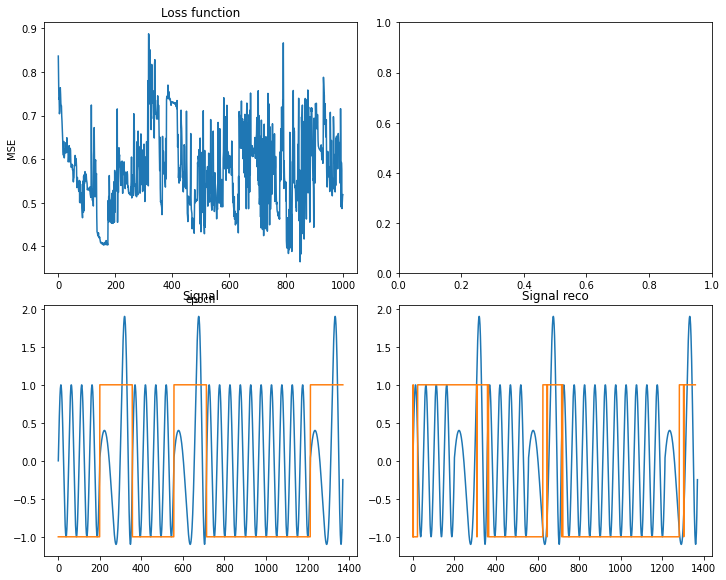

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.tight_layout()

axes[0, 0].set_title('Loss function')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].plot(train_loss)

axes[1, 0].set_title('Signal')
axes[1, 0].plot(signal)
axes[1, 0].plot(labels)

axes[1, 1].set_title('Signal reco')
axes[1, 1].plot(signal)
axes[1, 1].plot(predict)

---

**Сеть Хопфилда**

In [13]:
class HopfieldLayer(nn.Module):
    def __init__(self, in_features):
        super(HopfieldLayer, self).__init__()
        self.w = nn.Parameter(torch.zeros(in_features, in_features))
        self.b = nn.Parameter(torch.zeros(in_features))
        self.prev = torch.zeros(in_features)
        
    def set_initial_value(self, value):
        self.prev = value.detach().clone()
        
    def forward(self, input=0):
        out = torch.matmul(self.prev, self.w)
        out = torch.add(out, self.b)
        out = torch.clamp(out, min=-1, max=1)
        self.prev = out.detach().clone()
        return out

In [14]:
from PIL import Image
def load_image(path, width = 32, height = 24):
  image = Image.open(path)
  image = image.convert('RGB')
  image = image.resize((width, height), Image.ANTIALIAS)
  image = np.array(image, dtype = np.float32)
  image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.float32)
  image = (image - 127.5) / 127.5
  return image.flatten()

Mounted at /content/drive/


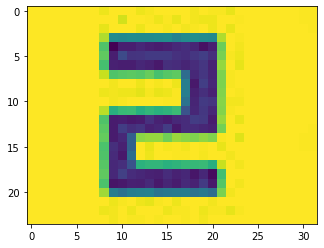

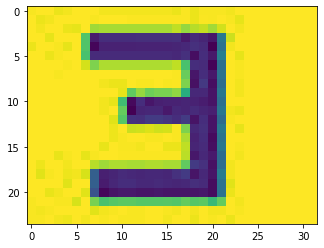

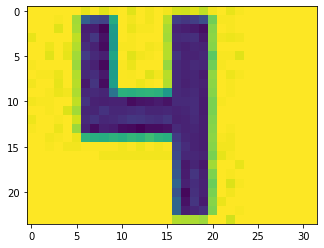

In [15]:
from google.colab import drive
drive.mount('/content/drive/')

images = []
images.append(load_image(path = "/content/drive/My Drive/img/2.jpg"))
images.append(load_image(path = "/content/drive/My Drive/img/3.jpg"))
images.append(load_image(path = "/content/drive/My Drive/img/4.jpg"))

fig = plt.figure(figsize=(6, 4))
plt.imshow(images[0].reshape(24, 32))
plt.show()
plt.imshow(images[1].reshape(24, 32))
plt.show()
plt.imshow(images[2].reshape(24, 32))
plt.show()

In [16]:
height = 24
width = 32

In [17]:
from torch.utils.data import DataLoader
dataloader = DataLoader(images, batch_size=1, shuffle=True)

In [18]:
hopfield = HopfieldLayer(width * height)

In [19]:
epochs = 1500
optim = torch.optim.Adam(hopfield.parameters(), lr=1e-5)
crit = nn.MSELoss()
hopfield.train()
train_loss = []

for epoch in tqdm(range(epochs), desc='Epochs', ncols=70):
    for img in dataloader:
        losses = []
        hopfield.set_initial_value(img)
        out = hopfield()
        loss = crit(out, img)

        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.item())

Epochs: 100%|█████████████████████| 1500/1500 [00:23<00:00, 64.43it/s]


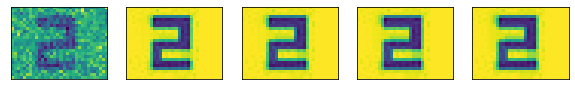

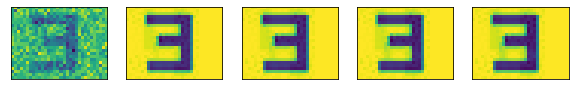

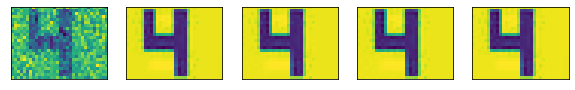

In [20]:
for img in images:
    out = torch.clamp(torch.tensor(img) + torch.randn(img.shape) / 4, -2, 2) / 2

    hopfield.eval()
    hopfield.set_initial_value(out)
    steps = 5
    fig = plt.figure(figsize=(steps * 2, 4))
    for i in range(steps):
        ax = fig.add_subplot(1, steps, i+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(out.detach().numpy().reshape(height, width))
        out = hopfield()
    plt.show()